In [1]:
# !pip install mplsoccer
# !pip install statsbombpy

In [2]:
from mplsoccer.pitch import Pitch
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from statsbombpy import sb
import pandas as pd
import warnings
from pandas.errors import SettingWithCopyWarning
from statsbombpy.api_client import NoAuthWarning

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=NoAuthWarning)

In [3]:
# ATTRIBUTES_LIST = ["Pass","Shot","Dribble"]
ATTRIBUTES_LIST = ["Pass","Shot","Dribble"]

<br><br><br><br>
### Jupyter - loading_bar_html

In [9]:
from IPython.display import display, HTML
loading_bar_html = """
<div id="progress-container" style="width: 50%; border: 1px solid #ccc; margin: 20px 0;">
  <div id="progress-bar" style="width: 0%; height: 20px; background-color: #4CAF50; text-align: center; line-height: 20px; color: white;"></div>
</div>
<script>
function updateProgressBar(progress) {
  var progressBar = document.getElementById('progress-bar');
  progressBar.style.width = progress + '%';
  progressBar.innerHTML = progress + '%';
}
</script>
"""

In [36]:
competition_id = 9
season_id = 281
all_events = []
matches = sb.matches(competition_id=competition_id, season_id=season_id)
matches_ids = matches["match_id"] #[3895074] #matches["match_id"]
match_number = len(matches_ids)

display(HTML(loading_bar_html)) # loading_bar_html
for process, match_id in enumerate(matches_ids):
    events = sb.events(match_id=match_id)
    all_events.append(events) 
    progress = int((process + 1) / match_number * 100) # loading_bar_html
    display(HTML("<script>updateProgressBar({})</script>".format(progress))) # loading_bar_html
print("__completed__!")
events_df = pd.concat(all_events, ignore_index=True)

__completed__!


<img src="https://i.ibb.co/54hgbWX/image.png">
<!-- events_df[events_df['type'] == "Shot"][["player","location","shot_statsbomb_xg","timestamp"]] -->

In [46]:
file_title = "leverkusen_2024" + "_"
pitch_color = "red"

Pass is completed! ➡️
Shot is completed! ➡️
Dribble is completed! ➡️


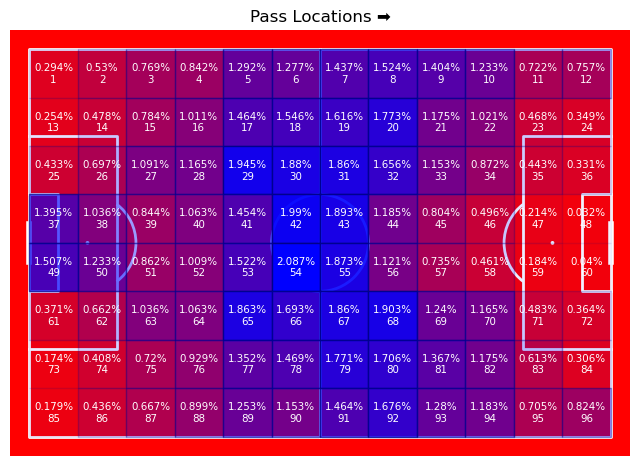

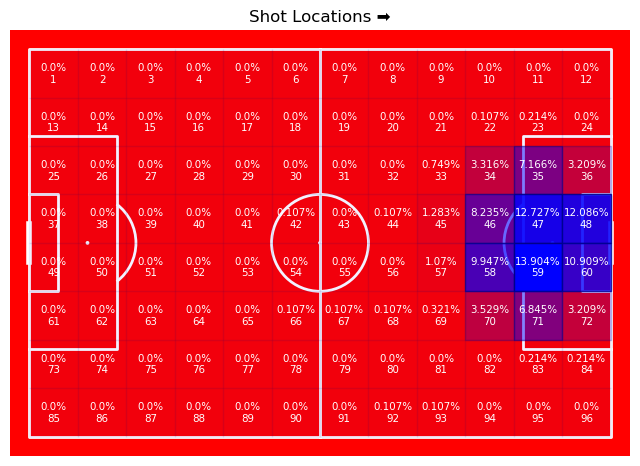

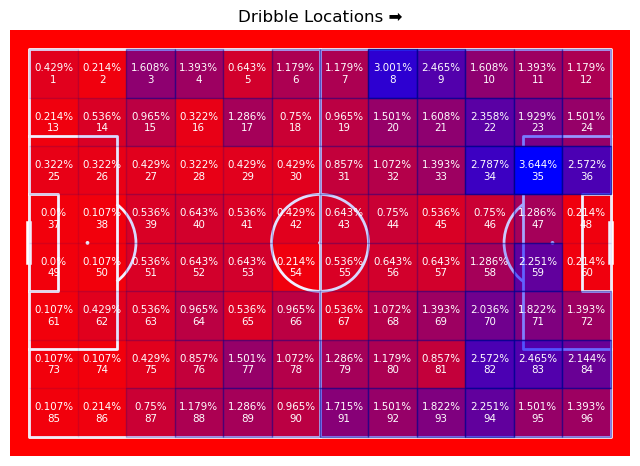

In [43]:
for ATTRIBUTE_TITLE in ATTRIBUTES_LIST:

    actions_df = events_df[events_df['type'] == ATTRIBUTE_TITLE].copy()  # Filter for actions
    actions_df['y'] = actions_df['location'].apply(lambda loc: loc[0])
    actions_df['x'] = actions_df['location'].apply(lambda loc: loc[1])
    
    pitch_yard_y = 120
    pitch_yard_x = 80
    yard_y_squares = 12
    yard_x_squares = 8
    
    y_intervals = [(i*pitch_yard_y/yard_y_squares, (i+1)*pitch_yard_y/yard_y_squares) for i in range(yard_y_squares)]  # Y-axis intervals
    x_intervals = [(i*pitch_yard_x/yard_x_squares, (i+1)*pitch_yard_x/yard_x_squares) for i in range(yard_x_squares)]  # X-axis intervals
    
    def get_interval(value, intervals):
        for start, end in intervals:
            if start <= value < end:
                return (start, end)
        return None
    
    counts_list = []
    for x_interval in x_intervals:
        for y_interval in y_intervals:
            count = actions_df[
                (actions_df['x'] >= x_interval[0]) & (actions_df['x'] <= x_interval[1]) &
                (actions_df['y'] >= y_interval[0]) & (actions_df['y'] <= y_interval[1])
            ].shape[0]
            counts_list.append({
                'x_interval': x_interval,
                'y_interval': y_interval,
                'count': count
            })
    counts_df = pd.DataFrame(counts_list)
    counts_df['percentage'] = round(counts_df['count'] / counts_df['count'].sum() * 100, 3)
    counts_df['Pitch_Number'] = range(1, len(counts_df) + 1)
    counts_df.to_csv(f"{file_title}_{ATTRIBUTE_TITLE}_locations.csv", index=False)

    def MinMaxNormalization(X):
        min_X = X.min()
        max_X = X.max()
        return (X-min_X) / (max_X-min_X)
    counts_df["alpha"] = MinMaxNormalization(counts_df["count"])
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color=pitch_color, line_color='white')
    fig, ax = plt.subplots(figsize=(8, 12))
    pitch.draw(ax=ax)
    def draw_intervals(df, ax):
        for _, row in df.iterrows():
            x_start, x_end = row['x_interval']
            y_start, y_end = row['y_interval']
            count = row['count']
            percentage = row['percentage']
            pitch_number = row['Pitch_Number']
            alphaValue = row['alpha']
            
            # Create a rectangle patch
            rect = patches.Rectangle(
                (y_start, x_start), 
                y_end - y_start,
                x_end - x_start, 
                linewidth=1,
                edgecolor='darkblue',
                facecolor='blue',
                alpha=max(0.05, alphaValue)
            )
            
            # Add rectangle to the plot
            ax.add_patch(rect)
            
            # Add text to the rectangles
            ax.text(
                (y_start + y_end) / 2,
                (x_start + x_end) / 2, 
                f'{percentage}%\n{pitch_number}', #f'{percentage}% \n {count} \n {pitch_number}',
                ha='center', va='center',
                fontsize=7.4, color='white'
            )
    draw_intervals(counts_df, ax)
    plt.title(f'{ATTRIBUTE_TITLE} Locations ➡️')
    saved_fig = fig.savefig(f"IMG/{file_title}{ATTRIBUTE_TITLE}_Locations.png", dpi=300, bbox_inches='tight')
    print(f'{ATTRIBUTE_TITLE} is completed! ➡️')

In [39]:
events_df['type'].unique()
events_df.columns

Index(['50_50', 'bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_recovery_failure', 'block_deflection',
       'block_save_block', 'carry_end_location', 'clearance_aerial_won',
       'clearance_body_part', 'clearance_head',
       ...
       'pass_straight', 'shot_open_goal', 'dribble_no_touch',
       'goalkeeper_shot_saved_off_target', 'shot_saved_off_target',
       'goalkeeper_shot_saved_to_post', 'shot_saved_to_post',
       'clearance_other', 'goalkeeper_success_out',
       'goalkeeper_success_in_play'],
      dtype='object', length=111)

In [40]:
tactics = pd.read_excel("tactical_index_fm23.xlsx")

In [47]:
fils = tactics.Philosophy.dropna().unique()

In [48]:
styles = tactics.Style.dropna().unique()

In [49]:
combs = []
for f in fils:
    for s in styles:
        combs.append(f"{f} - {s}")

In [50]:
combs

['Gegen - Direct',
 'Gegen - High Tempo',
 'Gegen - Slow Passing',
 'Gegen - Wing Play',
 'Tiki Taka - Direct',
 'Tiki Taka - High Tempo',
 'Tiki Taka - Slow Passing',
 'Tiki Taka - Wing Play',
 'Control - Direct',
 'Control - High Tempo',
 'Control - Slow Passing',
 'Control - Wing Play',
 'Counter - Direct',
 'Counter - High Tempo',
 'Counter - Slow Passing',
 'Counter - Wing Play',
 'Total Football - Direct',
 'Total Football - High Tempo',
 'Total Football - Slow Passing',
 'Total Football - Wing Play']